In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

class MoralAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        # Initialize moral weights (care, fairness, liberty)
        self.weights = np.random.dirichlet(np.ones(3))
        self.utility_history = []
        self.choice_history = []

    def step(self):
        # Get moral dilemma from model
        dilemma = self.model.dilemmas[self.model.schedule.steps % len(self.model.dilemmas)]
        
        # Calculate utilities for each option
        utilities = [np.dot(self.weights, outcome) for outcome in dilemma]
        
        # Choose best option
        choice = np.argmax(utilities)
        self.utility_history.append(utilities[choice])
        self.choice_history.append(choice)
        
        # Social learning
        if self.model.social_influence:
            self.learn_from_neighbors()

    def learn_from_neighbors(self):
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        if neighbors:
            # Calculate average neighbor weights
            neighbor_weights = [n.weights for n in neighbors]
            avg_weights = np.mean(neighbor_weights, axis=0)
            
            # Update weights (10% toward neighbors)
            self.weights = 0.9 * self.weights + 0.1 * avg_weights
            self.weights /= np.sum(self.weights)  # Normalize

class MoralModel(Model):
    def __init__(self, num_agents=100, social_influence=True):
        super().__init__()  # CRITICAL FIX: Initialize parent class
        self.num_agents = num_agents
        self.social_influence = social_influence
        self.schedule = RandomActivation(self)
        self.grid = NetworkGrid(nx.watts_strogatz_graph(num_agents, k=4, p=0.3))
        
        # Define moral dilemmas (trolley problem, vaccine distribution, etc.)
        self.dilemmas = [
            [np.array([0.8, -0.2, 0.1]), np.array([-0.1, 0.9, -0.3])],  # Care vs fairness
            [np.array([0.2, 0.6, -0.1]), np.array([0.7, -0.3, 0.4])],    # Fairness vs liberty
            [np.array([-0.3, 0.1, 0.9]), np.array([0.5, 0.5, -0.2])]     # Liberty vs equality
        ]
        
        # Create agents
        for i in range(num_agents):
            agent = MoralAgent(i, self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, i)
            
        # Data collection
        self.datacollector = DataCollector(
            agent_reporters={"Weights": lambda a: a.weights},
            model_reporters={"Moral_Diversity": self.calc_moral_diversity}
        )
    
    def calc_moral_diversity(self):
        weights = [agent.weights for agent in self.schedule.agents]
        return np.mean(np.std(weights, axis=0))
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Run simulation
model = MoralModel(num_agents=200, social_influence=True)
for _ in range(50):  # Run 50 steps
    model.step()

# Get collected data
agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

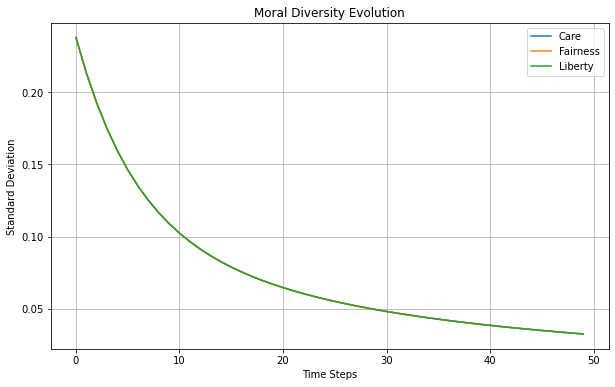

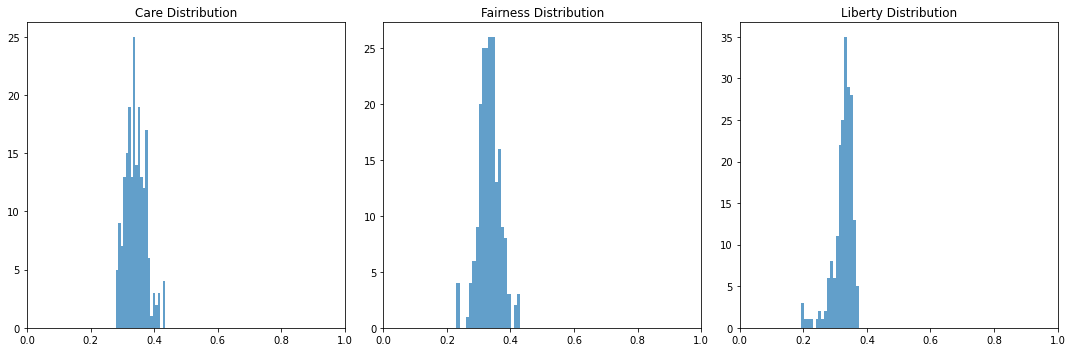

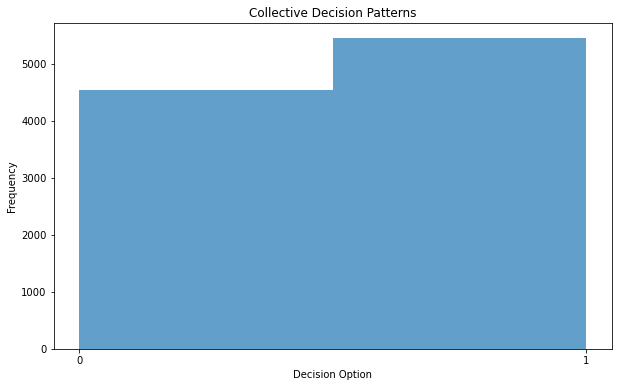

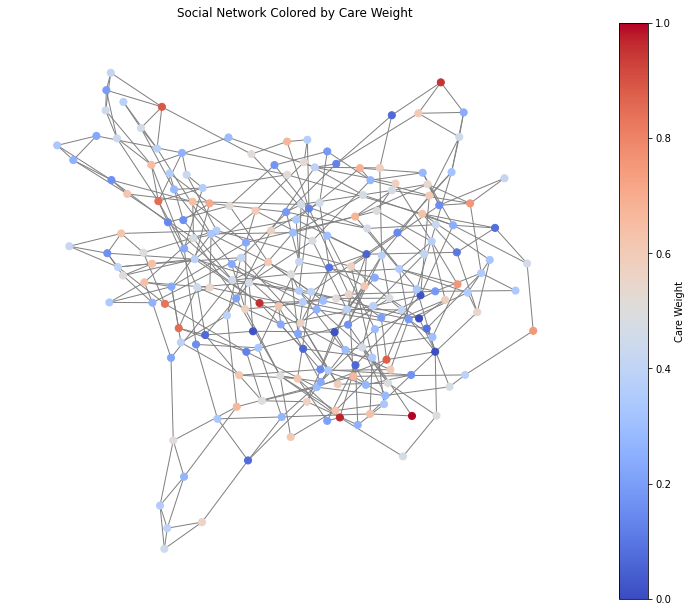

Care-Fairness Correlation: -0.52
Fairness-Liberty Correlation: -0.53
Liberty-Care Correlation: -0.44


In [4]:
# 1. Moral Evolution Over Time
plt.figure(figsize=(10, 6))
for i, weight in enumerate(['Care', 'Fairness', 'Liberty']):
    plt.plot(model_data.index, model_data['Moral_Diversity'], label=weight)
plt.xlabel("Time Steps")
plt.ylabel("Standard Deviation")
plt.title("Moral Diversity Evolution")
plt.legend()
plt.grid(True)
plt.show()

# 2. Final Moral Landscape
final_weights = agent_data.xs(49, level="Step")["Weights"].apply(np.array)
weights_matrix = np.vstack(final_weights.values)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, title in enumerate(['Care', 'Fairness', 'Liberty']):
    ax[i].hist(weights_matrix[:, i], bins=20, alpha=0.7)
    ax[i].set_title(f"{title} Distribution")
    ax[i].set_xlim(0, 1)
plt.tight_layout()

# 3. Decision Patterns Analysis
plt.figure(figsize=(10, 6))
all_choices = np.concatenate([a.choice_history for a in model.schedule.agents])
plt.hist(all_choices, bins=len(model.dilemmas[0]), alpha=0.7)
plt.xlabel("Decision Option")
plt.ylabel("Frequency")
plt.title("Collective Decision Patterns")
plt.xticks(range(len(model.dilemmas[0])))
plt.show()

# 4. Network Visualization with Moral Clusters
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(model.grid.G)
colors = weights_matrix[:, 0]  # Color by care weight

nx.draw(model.grid.G, pos, node_color=colors, 
        cmap=plt.cm.coolwarm, node_size=50, 
        with_labels=False, edge_color="grey")
plt.title("Social Network Colored by Care Weight")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm), label="Care Weight")
plt.show()

# 5. Correlation Analysis
from scipy.stats import pearsonr

care_fairness = pearsonr(weights_matrix[:, 0], weights_matrix[:, 1])[0]
fairness_liberty = pearsonr(weights_matrix[:, 1], weights_matrix[:, 2])[0]
liberty_care = pearsonr(weights_matrix[:, 2], weights_matrix[:, 0])[0]

print(f"Care-Fairness Correlation: {care_fairness:.2f}")
print(f"Fairness-Liberty Correlation: {fairness_liberty:.2f}")
print(f"Liberty-Care Correlation: {liberty_care:.2f}")

In [5]:
# Run multiple simulations
correlations = []
for _ in range(10):
    model = MoralModel()
    # ... run simulation ...
    weights = np.array([a.weights for a in model.schedule.agents])
    corr = np.corrcoef(weights.T)
    correlations.append(corr)

avg_corr = np.mean(correlations, axis=0)

Text(0.5, 1.0, 'Moral Value Projection')

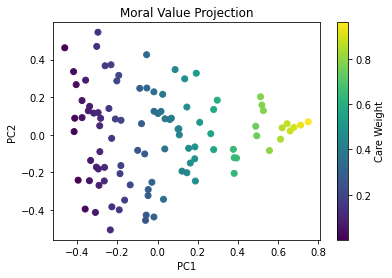

In [6]:
from sklearn.decomposition import PCA

weights_matrix = np.array([agent.weights for agent in model.schedule.agents])
pca = PCA(n_components=2)
coords = pca.fit_transform(weights_matrix)

plt.scatter(coords[:,0], coords[:,1], c=weights_matrix[:,0], cmap='viridis')
plt.colorbar(label='Care Weight')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Moral Value Projection')

In [7]:
# See which values "win" in dilemmas
care_wins = 0
fairness_wins = 0
liberty_wins = 0

for agent in model.schedule.agents:
    for choice in agent.choice_history:
        outcome = model.dilemmas[choice]
        winning_value = np.argmax(outcome)
        if winning_value == 0: care_wins += 1
        elif winning_value == 1: fairness_wins += 1
        else: liberty_wins += 1